## Creacion de modelo Predictivo.

In [42]:
%load_ext autoreload
%autoreload 2

# Tratamiento de datos
# -----------------------------------------------------------------------
import pandas as pd
import numpy as np

# Visualizaciones
# -----------------------------------------------------------------------
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import tree

# Para realizar la regresión lineal y la evaluación del modelo
# -----------------------------------------------------------------------
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error


from sklearn.model_selection import KFold,LeaveOneOut, cross_val_score


from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

import warnings

import sys
sys.path.append('../..')

from src import soporte_regresion as sup_regre

##aplicar configuraciones
#------------------------------------------------------------------------
warnings.filterwarnings('ignore')
pd.set_option('display.max_info_columns', 50)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format) #eliminamos la notacion cientifica

tqdm.pandas()


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


---
---

## Importamos los datos ya tratados en el notebook ```3_Encoding.ipynb```.

In [43]:
df = pd.read_csv('../../datos/tratados/encoded_propiedades_provincia_madrid.csv', index_col=0).reset_index(drop=True)
df.sample()

,numPhotos,price,size,exterior,rooms,bathrooms,municipality,showAddress,distance,hasVideo,newDevelopment,hasPlan,has3DTour,has360,topNewDevelopment,district,neighborhood,hasLift,propertyType_chalet,propertyType_countryHouse,propertyType_duplex,propertyType_flat,propertyType_penthouse,propertyType_studio,status_good,status_newdevelopment,status_renew,floor_1,floor_14,floor_2,floor_3,floor_4,floor_5,floor_6,floor_7,floor_8,floor_Desconocido,floor_bj,floor_en,floor_ss,floor_st
56,0.62,600.00,-0.28,True,-1.00,0.00,686.09,False,0.58,False,False,False,False,False,False,686.01,679.79,True,0.00,0.00,0.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00


In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 353 entries, 0 to 352
Data columns (total 41 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   numPhotos                  353 non-null    float64
 1   price                      353 non-null    float64
 2   size                       353 non-null    float64
 3   exterior                   353 non-null    bool   
 4   rooms                      353 non-null    float64
 5   bathrooms                  353 non-null    float64
 6   municipality               353 non-null    float64
 7   showAddress                353 non-null    bool   
 8   distance                   353 non-null    float64
 9   hasVideo                   353 non-null    bool   
 10  newDevelopment             353 non-null    bool   
 11  hasPlan                    353 non-null    bool   
 12  has3DTour                  353 non-null    bool   
 13  has360                     353 non-null    bool   

## Creamos el modelo para predecir el precio.

### Creamos un modelo de arbol sin parametros para ver que tal

In [45]:
X = df.drop(columns=['price'])
y = df[['price']]

X_train, X_test, y_train,y_test = train_test_split(X,y, train_size=0.8, random_state=42, shuffle=True)

In [46]:
modelo_arbol_vacio= DecisionTreeRegressor()         
modelo_arbol_vacio.fit(X_train, y_train)
y_pred_test_arb_vacio= modelo_arbol_vacio.predict(X_test)
y_pred_train_arb_vacio= modelo_arbol_vacio.predict(X_train)
df_metricas_arbol_vacio= sup_regre.metricas(y_train, y_pred_train_arb_vacio, y_test, y_pred_test_arb_vacio)
df_metricas_arbol_vacio

,train,test
r2_score,1.00,0.14
MAE,0.03,36.80
MSE,0.14,2532.83
RMSE,0.38,50.33


## Ahora creamos el modelo con parametros.

In [47]:
# Parámetros a evaluar
params_arbol = {
    'max_depth': [3, 5, 7, 10],
    'min_samples_split': [10, 50, 100, 200],
    'min_samples_leaf': [10, 50, 100, 200],
    'max_leaf_nodes': [4, 6, 8, 10, 20, 30]
}

grid_search_arbol=GridSearchCV(DecisionTreeRegressor(), param_grid=params_arbol, cv=5, scoring= "neg_mean_squared_error", n_jobs=-1)

grid_search_arbol.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [3, 5, 7, 10],
                         'max_leaf_nodes': [4, 6, 8, 10, 20, 30],
                         'min_samples_leaf': [10, 50, 100, 200],
                         'min_samples_split': [10, 50, 100, 200]},
             scoring='neg_mean_squared_error')

In [48]:
modelo_final_arbol=grid_search_arbol.best_estimator_  #para ver el mejor arbol que me ha elegido
modelo_final_arbol

DecisionTreeRegressor(max_depth=3, max_leaf_nodes=8, min_samples_leaf=10,
                      min_samples_split=10)

In [49]:
y_pred_test_arb= modelo_final_arbol.predict(X_test)
y_pred_train_arb= modelo_final_arbol.predict(X_train)
df_metricas_arbol= sup_regre.metricas(y_train, y_pred_train_arb, y_test, y_pred_test_arb)
df_metricas_arbol=df_metricas_arbol.T
df_metricas_arbol.reset_index(inplace=True)
df_metricas_arbol

,index,r2_score,MAE,MSE,RMSE
0,train,0.53,32.78,1866.79,43.21
1,test,0.37,34.87,1859.21,43.12


---
---

### Modelo 2

### Ahora vamos a crearlo con unos parametros más acotados

In [ ]:
##pd.DataFrame(modelo_final_arbol.feature_importances_, columns= ["Importancia"], index= X.columns).sort_values(by = "Importancia", ascending=False)

In [103]:
# Parámetros a evaluar
params_arbol_prueba2 = {
    'max_depth': [2,3,4,5],
    'min_samples_split': [5, 10, 15, 20],
    'min_samples_leaf': [2, 5, 10],
    'max_leaf_nodes': [5, 10, 12, 15]
}

grid_search_arbol_2=GridSearchCV(DecisionTreeRegressor(), param_grid=params_arbol_prueba2 , cv=5, scoring= "neg_mean_squared_error", n_jobs=-1)

grid_search_arbol_2.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=DecisionTreeRegressor(), n_jobs=-1,
             param_grid={'max_depth': [2, 3, 4, 5],
                         'max_leaf_nodes': [5, 10, 12, 15],
                         'min_samples_leaf': [2, 5, 10],
                         'min_samples_split': [5, 10, 15, 20]},
             scoring='neg_mean_squared_error')

In [104]:
grid_search_arbol_2.best_params_

{'max_depth': 4,
 'max_leaf_nodes': 12,
 'min_samples_leaf': 10,
 'min_samples_split': 5}

In [105]:
modelo_final_arbol_2=grid_search_arbol_2.best_estimator_  #para ver el mejor arbol que me ha elegido
modelo_final_arbol_2

DecisionTreeRegressor(max_depth=4, max_leaf_nodes=12, min_samples_leaf=10,
                      min_samples_split=5)

In [106]:
y_pred_test_arb_2= modelo_final_arbol_2.predict(X_test)
y_pred_train_arb_2= modelo_final_arbol_2.predict(X_train)
df_metricas_arbol_2= sup_regre.metricas(y_train, y_pred_train_arb_2, y_test, y_pred_test_arb_2)

df_metricas_arbol_2=df_metricas_arbol_2.T.reset_index()
df_metricas_arbol_2

,index,r2_score,MAE,MSE,RMSE
0,train,0.55,31.48,1762.41,41.98
1,test,0.44,31.99,1646.28,40.57


## Visualizamos los resultados

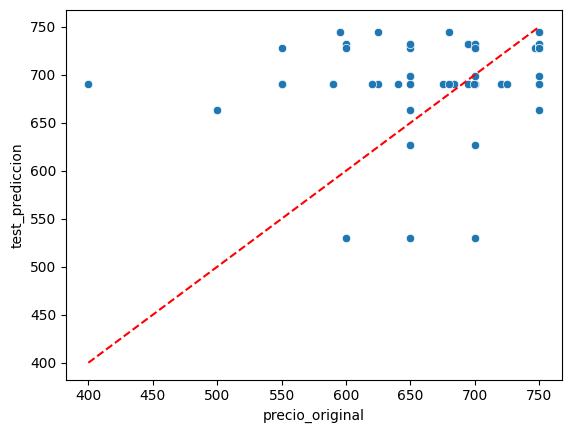

In [107]:
pred_ytest=pd.DataFrame(y_pred_test_arb_2, columns=["y_pred_test_ult"])
pred_ytrain=pd.DataFrame(y_pred_train_arb_2, columns=["y_pred_train_ult"])

df_fin=pd.DataFrame()
df_fin=pd.concat([df_fin, pred_ytest, pred_ytrain, y], ignore_index=True, axis=1)

df_fin.columns= ["test_prediccion", "train_prediccion", "precio_original"]

df_fin.reset_index(inplace=True)

sns.scatterplot(x="precio_original", y="test_prediccion", data= df_fin)
plt.plot([df_fin["precio_original"].min(), df_fin["precio_original"].max()],
         [df_fin["precio_original"].min(), df_fin["precio_original"].max()],
         color='red', linestyle='--', label='x = y')


<h3 style="color: #9966CC"><b>
Probar a eliminar variables que no sean importantes para el modelo
</b></h3>